# Modelo Predictivo para Poverty Headcount Ratio en Honduras

Este notebook desarrolla un modelo predictivo y an√°lisis de regresi√≥n para el **Poverty Headcount Ratio** utilizando datos socioecon√≥micos de Honduras.


## 1. Import Required Libraries

Importamos las librer√≠as necesarias para el an√°lisis de datos y machine learning.

In [2]:
# Librer√≠as para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librer√≠as para visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librer√≠as para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Load and Explore Poverty Data

Cargamos los datasets relacionados con pobreza y otros indicadores socioecon√≥micos.

In [3]:
# Cargar datasets espec√≠ficos para el modelo predictivo
poverty_df = pd.read_csv(f'../Datasets/Povert_headcount_ratio_at_societal_poverty_lines.csv')

# Cargar segundo dataset de pobreza (Excel)
poverty_excel_df = pd.read_excel(f'../Datasets/API_SI.POV.DDAY_DS2_en_excel_v2_607870.xls')


In [5]:
# Exploraci√≥n m√°s detallada de ambos datasets
print(" ESTAD√çSTICAS DESCRIPTIVAS (CSV):")
print(poverty_df.describe())

print("\n INFORMACI√ìN DETALLADA (CSV):")
print(poverty_df.info())

print("\n VALORES FALTANTES (CSV):")
print(poverty_df.isnull().sum())

if poverty_excel_df is not None:
    print("\n ESTAD√çSTICAS DESCRIPTIVAS (EXCEL):")
    print(poverty_excel_df.describe())
    
    print("\n INFORMACI√ìN DETALLADA (EXCEL):")
    print(poverty_excel_df.info())

 ESTAD√çSTICAS DESCRIPTIVAS (CSV):
       1960  1961  1962  1963  1964  1965  1966  1967       1968       1969  \
count   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   2.000000   2.000000   
mean    NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  12.850000  13.450000   
std     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   6.858936   6.010408   
min     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5   8.000000   9.200000   
25%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  10.425000  11.325000   
50%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  12.850000  13.450000   
75%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  15.275000  15.575000   
max     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  17.700000  17.700000   

       ...       2016       2017        2018       2019       2020       2021  \
count  ...  95.000000  90.000000  105.000000  86.000000  79.000000  88.000000   
mean   ...  23.066316  20.951111   22.332381  21.037209  20.418987  21.939773   
std    ...

## 3. Data Preprocessing and Cleaning

Limpiamos y preparamos los datos para el an√°lisis y modelado.

In [6]:
def clean_dataset(df, dataset_name):
    """
    Funci√≥n para limpiar datasets de manera consistente
    """
    print(f"\nLimpiando dataset: {dataset_name}")
    print(f"Dimensiones originales: {df.shape}")
    
    # Copia del dataset
    df_clean = df.copy()
    
    # Filtrar solo Honduras si existe columna de pa√≠s
    if 'Country Name' in df_clean.columns:
        honduras_mask = df_clean['Country Name'].str.contains('Honduras', case=False, na=False)
        df_clean = df_clean[honduras_mask]
        print(f"Datos filtrados para Honduras: {df_clean.shape}")
    
    # Identificar columnas de a√±os (formato num√©rico)
    year_columns = [col for col in df_clean.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if year_columns:
        # Filtrar a√±os
        years_2010_2022 = [col for col in year_columns if 2010 <= int(col) <= 2022]
        
        # Seleccionar columnas relevantes
        keep_columns = [col for col in df_clean.columns if not str(col).isdigit() or str(col) in years_2010_2022]
        df_clean = df_clean[keep_columns]
        
        print(f"A√±os incluidos: {sorted([int(col) for col in years_2010_2022])}")
    
    print(f"Dimensiones finales: {df_clean.shape}")
    return df_clean

# Limpiar datasets de pobreza
poverty_clean = clean_dataset(poverty_df, "Poverty Headcount Ratio (CSV)")

if poverty_excel_df is not None:
    poverty_excel_clean = clean_dataset(poverty_excel_df, "Poverty Dataset (Excel)")
else:
    poverty_excel_clean = None
    print("Dataset de Excel no disponible para limpieza")


Limpiando dataset: Poverty Headcount Ratio (CSV)
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
A√±os incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Poverty Dataset (Excel)
Dimensiones originales: (269, 69)
Dimensiones finales: (269, 69)


In [7]:
def reshape_to_long_format(df, dataset_name, value_column_name):
    """
    Convierte el dataset del formato wide a long format
    """
    print(f"\nConvirtiendo {dataset_name} a formato largo...")
    
    # Identificar columnas de a√±os
    year_columns = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if not year_columns:
        print(f"No se encontraron columnas de a√±os en {dataset_name}")
        return None
    
    # Columnas que no son a√±os
    id_columns = [col for col in df.columns if col not in year_columns]
    
    # Reshape a formato largo
    df_long = pd.melt(df, 
                      id_vars=id_columns, 
                      value_vars=year_columns,
                      var_name='Year', 
                      value_name=value_column_name)
    
    # Convertir Year a int
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Limpiar valores nulos
    df_long = df_long.dropna(subset=[value_column_name])
    
    print(f"Dimensiones del dataset en formato largo: {df_long.shape}")
    return df_long

# Convertir datasets a formato largo
poverty_long = reshape_to_long_format(poverty_clean, "Poverty CSV", "Poverty_Headcount_Ratio")

if poverty_excel_clean is not None:
    poverty_excel_long = reshape_to_long_format(poverty_excel_clean, "Poverty Excel", "Poverty_Excel_Indicator")
    print("\nAmbos datasets convertidos a formato largo")
else:
    poverty_excel_long = None
    print("\nSolo dataset CSV convertido a formato largo")


Convirtiendo Poverty CSV a formato largo...
Dimensiones del dataset en formato largo: (10, 7)

Convirtiendo Poverty Excel a formato largo...
No se encontraron columnas de a√±os en Poverty Excel

Ambos datasets convertidos a formato largo


## 4. Feature Selection and Engineering

Seleccionamos y creamos variables relevantes para el modelo predictivo.

In [8]:
# Crear dataset combinado para el modelado
def create_combined_dataset():
    """
    Combina los datasets de pobreza en uno solo para el modelado
    """
    
    if poverty_long is None or poverty_long.empty:
        return None
    
    # Iniciar con el dataset principal de pobreza
    combined_df = poverty_long[['Year', 'Poverty_Headcount_Ratio']].copy()
    
    # Si hay dataset de Excel, intentar combinar
    if poverty_excel_long is not None and not poverty_excel_long.empty:
        try:
            # Intentar merge con el dataset de Excel
            excel_data = poverty_excel_long[['Year', 'Poverty_Excel_Indicator']].copy()
            combined_df = pd.merge(combined_df, excel_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar dataset de Excel: {e}")
    
    # Eliminar filas con valores nulos en la variable objetivo principal
    combined_df = combined_df.dropna(subset=['Poverty_Headcount_Ratio'])
    
    return combined_df

# Crear dataset combinado
model_data = create_combined_dataset()

if model_data is not None:
    print("\nPrimeras 5 filas:")
    display(model_data.head())


Primeras 5 filas:


Year  Poverty_Headcount_Ratio
0  2010                     34.6
1  2011                     34.9
2  2012                     37.3
3  2013                     35.4
4  2014                     35.1

In [10]:
# Feature Engineering - Crear variables adicionales
if model_data is not None and len(model_data) > 0:
    print("Creando variables adicionales (Feature Engineering)...")
    
    # Crear variables temporales
    model_data['Year_normalized'] = (model_data['Year'] - model_data['Year'].min()) / (model_data['Year'].max() - model_data['Year'].min())
    model_data['Year_squared'] = model_data['Year'] ** 2
    model_data['Time_trend'] = range(len(model_data))
    
    # Variables de lag (valores del a√±o anterior) si hay suficientes datos
    if len(model_data) > 1:
        model_data = model_data.sort_values('Year')
        model_data['Poverty_lag1'] = model_data['Poverty_Headcount_Ratio'].shift(1)
        
        # Si hay datos del Excel, crear variables de lag tambi√©n
        if 'Poverty_Excel_Indicator' in model_data.columns:
            model_data['Poverty_Excel_lag1'] = model_data['Poverty_Excel_Indicator'].shift(1)
        
        # Crear variables de cambio porcentual
        for col in model_data.select_dtypes(include=[np.number]).columns:
            if col not in ['Year', 'Year_normalized', 'Year_squared', 'Time_trend'] and not col.endswith('_lag1'):
                change_col = f'{col}_change'
                model_data[change_col] = model_data[col].pct_change()
    
    # Variables de interacci√≥n si hay ambos datasets de pobreza
    if 'Poverty_Excel_Indicator' in model_data.columns:
        model_data['Poverty_Ratio_CSV_Excel'] = model_data['Poverty_Headcount_Ratio'] / (model_data['Poverty_Excel_Indicator'] + 0.001)
        model_data['Poverty_Diff_CSV_Excel'] = model_data['Poverty_Headcount_Ratio'] - model_data['Poverty_Excel_Indicator']
    
    # Variables categ√≥ricas basadas en per√≠odos
    model_data['Period'] = pd.cut(model_data['Year'], 
                                  bins=[2009, 2014, 2018, 2022], 
                                  labels=['2010-2014', '2015-2018', '2019-2022'])
    
    # Eliminar filas con NaN generados por feature engineering
    model_data_clean = model_data.dropna()
    
    print(f"Variables creadas. Nuevo tama√±o: {model_data_clean.shape}")
    print(f"Nuevas columnas: {[col for col in model_data_clean.columns if col not in ['Year', 'Poverty_Headcount_Ratio']]}")
    
    # Matriz de correlaci√≥n
    numeric_cols = model_data_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = model_data_clean[numeric_cols].corr()
    
    # Visualizar correlaciones
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlaci√≥n - Variables para Modelo de Pobreza', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay datos suficientes para feature engineering")

Creando variables adicionales (Feature Engineering)...
Variables creadas. Nuevo tama√±o: (8, 9)
Nuevas columnas: ['Year_normalized', 'Year_squared', 'Time_trend', 'Poverty_lag1', 'Poverty_Headcount_Ratio_change', 'Period', 'Poverty_Headcount_Ratio_change_change']


## 5. Split Data for Training and Testing

Dividimos los datos en conjuntos de entrenamiento y prueba.

In [21]:
# Preparaci√≥n de datos para modelado
if 'model_data_clean' in locals() and len(model_data_clean) > 0:
    print("Preparando datos para modelado...")
    
    # Seleccionar features num√©ricas (excluyendo variables no predictivas)
    feature_columns = [col for col in model_data_clean.select_dtypes(include=[np.number]).columns 
                       if col not in ['Poverty_Headcount_Ratio', 'Year']]
    
    # Variables predictoras (X) y variable objetivo (y)
    X = model_data_clean[feature_columns].copy()
    y = model_data_clean['Poverty_Headcount_Ratio'].copy()
    
    print(f"Variable objetivo: Poverty_Headcount_Ratio")
    print(f"Features seleccionadas ({len(feature_columns)}): {feature_columns}")
    print(f"Tama√±o del dataset: {X.shape}")
    
    # Verificar si hay suficientes datos para split
    if len(X) > 3:
        # Split temporal: usar √∫ltimos a√±os para test
        # Ordenar por a√±o para split temporal
        data_with_year = model_data_clean.copy()
        data_with_year = data_with_year.sort_values('Year')
        
        # Usar 70% para entrenamiento, 30% para test
        split_index = int(0.7 * len(data_with_year))
        
        X_train = data_with_year[feature_columns].iloc[:split_index]
        X_test = data_with_year[feature_columns].iloc[split_index:]
        y_train = data_with_year['Poverty_Headcount_Ratio'].iloc[:split_index]
        y_test = data_with_year['Poverty_Headcount_Ratio'].iloc[split_index:]
        
        years_train = data_with_year['Year'].iloc[:split_index]
        years_test = data_with_year['Year'].iloc[split_index:]
        
        print(f"\nSplit temporal realizado:")
        print(f"Entrenamiento: {len(X_train)} observaciones (a√±os {years_train.min()}-{years_train.max()})")
        print(f"Prueba: {len(X_test)} observaciones (a√±os {years_test.min()}-{years_test.max()})")
        
        # Tambi√©n hacer split aleatorio para comparaci√≥n
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
            X, y, test_size=0.3, random_state=42)
        
        print(f"\nSplit aleatorio realizado:")
        print(f"Entrenamiento: {len(X_train_rand)} observaciones")
        print(f"Prueba: {len(X_test_rand)} observaciones")
        
        # Mostrar estad√≠sticas de los splits
        print(f"\nEstad√≠sticas de los conjuntos:")
        print(f"Train temporal - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
        print(f"Test temporal - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")
        print(f"Train aleatorio - Media: {y_train_rand.mean():.2f}, Std: {y_train_rand.std():.2f}")
        print(f"Test aleatorio - Media: {y_test_rand.mean():.2f}, Std: {y_test_rand.std():.2f}")
        
    else:
        print("No hay suficientes datos para hacer split. Se usar√° validaci√≥n cruzada.")
        X_train, X_test, y_train, y_test = X, X, y, y
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = X, X, y, y
        
else:
    print("No hay datos limpios disponibles para modelado")

Preparando datos para modelado...
Variable objetivo: Poverty_Headcount_Ratio
Features seleccionadas (5): ['Year_normalized', 'Year_squared', 'Time_trend', 'Poverty_lag1', 'Poverty_Headcount_Ratio_change']
Tama√±o del dataset: (9, 5)

Split temporal realizado:
Entrenamiento: 6 observaciones (a√±os 2011-2016)
Prueba: 3 observaciones (a√±os 2017-2019)

Split aleatorio realizado:
Entrenamiento: 6 observaciones
Prueba: 3 observaciones

Estad√≠sticas de los conjuntos:
Train temporal - Media: 35.65, Std: 0.86
Test temporal - Media: 34.60, Std: 0.62
Train aleatorio - Media: 35.05, Std: 0.51
Test aleatorio - Media: 35.80, Std: 1.45


## 6. Build Regression Model

Creamos y entrenamos diferentes modelos de regresi√≥n.

In [28]:
# Definir m√∫ltiples modelos de regresi√≥n
def create_regression_models():
    """
    Crear diccionario con diferentes modelos de regresi√≥n
    """
    models = {
        'Linear_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        
        'Ridge_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0, random_state=42))
        ]),
        
        'Lasso_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=1000))
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            max_depth=3,
            min_samples_split=2
        ),
        
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=3,
            learning_rate=0.1
        ),
        
        'Polynomial_Regression': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    }
    
    return models

# Crear modelos
if 'X_train' in locals():
    print("Creando modelos de regresi√≥n...")
    models = create_regression_models()
    
    print(f"{len(models)} modelos creados:")
    for name in models.keys():
        print(f"  - {name}")
        
    # Verificar dimensiones
    print(f"\nDimensiones de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de prueba: {X_test.shape}")
else:
    print("No hay datos de entrenamiento disponibles")

Creando modelos de regresi√≥n...
6 modelos creados:
  - Linear_Regression
  - Ridge_Regression
  - Lasso_Regression
  - Random_Forest
  - Gradient_Boosting
  - Polynomial_Regression

Dimensiones de entrenamiento: (6, 5)
Dimensiones de prueba: (3, 5)


## 7. Model Training and Validation

Entrenamos los modelos y realizamos validaci√≥n cruzada.

In [29]:
# Entrenar y evaluar modelos
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, split_name=""):
    """
    Entrena y eval√∫a m√∫ltiples modelos
    """
    results = {}
    
    print(f"Entrenando modelos {split_name}...")
    
    for name, model in models.items():
        try:
            print(f"\Entrenando {name}...")
            
            # Entrenar modelo
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # M√©tricas de entrenamiento
            train_r2 = r2_score(y_train, y_pred_train)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            train_mae = mean_absolute_error(y_train, y_pred_train)
            
            # M√©tricas de prueba
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Validaci√≥n cruzada (solo si hay suficientes datos)
            cv_scores = []
            if len(X_train) > 3:
                try:
                    cv_scores = cross_val_score(model, X_train, y_train, cv=min(3, len(X_train)), 
                                                 scoring='r2', n_jobs=-1)
                except:
                    cv_scores = [train_r2]  # Fallback si CV falla
            else:
                cv_scores = [train_r2]
            
            # Guardar resultados
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'cv_mean': np.mean(cv_scores),
                'cv_std': np.std(cv_scores),
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }
            
            print(f"R¬≤ Test: {test_r2:.4f}, RMSE: {test_rmse:.4f}, CV R¬≤: {np.mean(cv_scores):.4f}¬±{np.std(cv_scores):.4f}")
            
        except Exception as e:
            print(f"Error entrenando {name}: {str(e)}")
            continue
    
    return results

# Entrenar modelos con ambos splits
if 'models' in locals() and 'X_train' in locals():
    # Split temporal
    results_temporal = train_and_evaluate_models(models, X_train, y_train, X_test, y_test, "(Split Temporal)")
    
    # Split aleatorio
    results_random = train_and_evaluate_models(models, X_train_rand, y_train_rand, X_test_rand, y_test_rand, "(Split Aleatorio)")
    
    print("\nEntrenamiento completado!")
else:
    print("No se pueden entrenar los modelos - faltan datos o modelos")

Entrenando modelos (Split Temporal)...
\Entrenando Linear_Regression...
R¬≤ Test: 0.9795, RMSE: 0.0731, CV R¬≤: 0.8709¬±0.1393
\Entrenando Ridge_Regression...
R¬≤ Test: 0.9795, RMSE: 0.0731, CV R¬≤: 0.8709¬±0.1393
\Entrenando Ridge_Regression...
R¬≤ Test: -0.0792, RMSE: 0.5297, CV R¬≤: -1.2653¬±0.3571
\Entrenando Lasso_Regression...
R¬≤ Test: -0.0792, RMSE: 0.5297, CV R¬≤: -1.2653¬±0.3571
\Entrenando Lasso_Regression...
R¬≤ Test: -0.1648, RMSE: 0.5503, CV R¬≤: -0.9460¬±1.3582
\Entrenando Random_Forest...
R¬≤ Test: -0.1648, RMSE: 0.5503, CV R¬≤: -0.9460¬±1.3582
\Entrenando Random_Forest...
R¬≤ Test: -3.2975, RMSE: 1.0570, CV R¬≤: -7.2096¬±4.9873
\Entrenando Gradient_Boosting...
R¬≤ Test: -3.2975, RMSE: 1.0570, CV R¬≤: -7.2096¬±4.9873
\Entrenando Gradient_Boosting...
R¬≤ Test: -4.0518, RMSE: 1.1461, CV R¬≤: -11.8995¬±12.2501
\Entrenando Polynomial_Regression...
R¬≤ Test: -6.1939, RMSE: 1.3676, CV R¬≤: -7.2178¬±8.7473
Entrenando modelos (Split Aleatorio)...
\Entrenando Linear_Regression..

## 8. Model Evaluation and Metrics

Evaluamos el desempe√±o de los modelos y comparamos m√©tricas.

COMPARACI√ìN DE MODELOS:


Modelo      Split R¬≤ Train  R¬≤ Test RMSE Test MAE Test  \
0       Linear_Regression   Temporal   0.9999   0.9795    0.0731   0.0675   
1        Ridge_Regression   Temporal   0.8565  -0.0792    0.5297   0.5056   
2        Lasso_Regression   Temporal   0.8528  -0.1648    0.5503   0.5275   
3           Random_Forest   Temporal   0.8007  -3.2975    1.0570   0.9152   
4       Gradient_Boosting   Temporal   1.0000  -4.0518    1.1461   1.0146   
5   Polynomial_Regression   Temporal   1.0000  -6.1939    1.3676   1.3553   
6       Linear_Regression  Aleatorio   1.0000   0.9994    0.0293   0.0277   
7        Ridge_Regression  Aleatorio   0.6680   0.5793    0.7693   0.6726   
8        Lasso_Regression  Aleatorio   0.2083  -0.0460    1.2130   1.0527   
9           Random_Forest  Aleatorio   0.6928  -0.2806    1.3422   1.0958   
10      Gradient_Boosting  Aleatorio   1.0000  -0.3175    1.3614   1.1656   
11  Polynomial_Regression  Aleatorio   1.0000   0.9865    0.1380   0.1225   

           CV R¬≤ (Œº¬±œÉ)  
0        0.8709¬±0.1393  
1       -1.2653¬±0.3571  
2       -0.9460¬±1.3582  
3       -7.2096¬±4.9873  
4     -11.8995¬±12.2501  
5       -7.2178¬±8.7473  
6       -0.2424¬±1.6397  
7   -126.2017¬±153.1018  
8   -105.8213¬±128.2058  
9    -75.3038¬±100.1485  
10  -128.9561¬±166.1373  
11    -51.8529¬±67.5172


üèÜ MEJORES MODELOS:
Split Temporal: Linear_Regression (R¬≤ = 0.9795)
Split Aleatorio: Linear_Regression (R¬≤ = 0.9994)


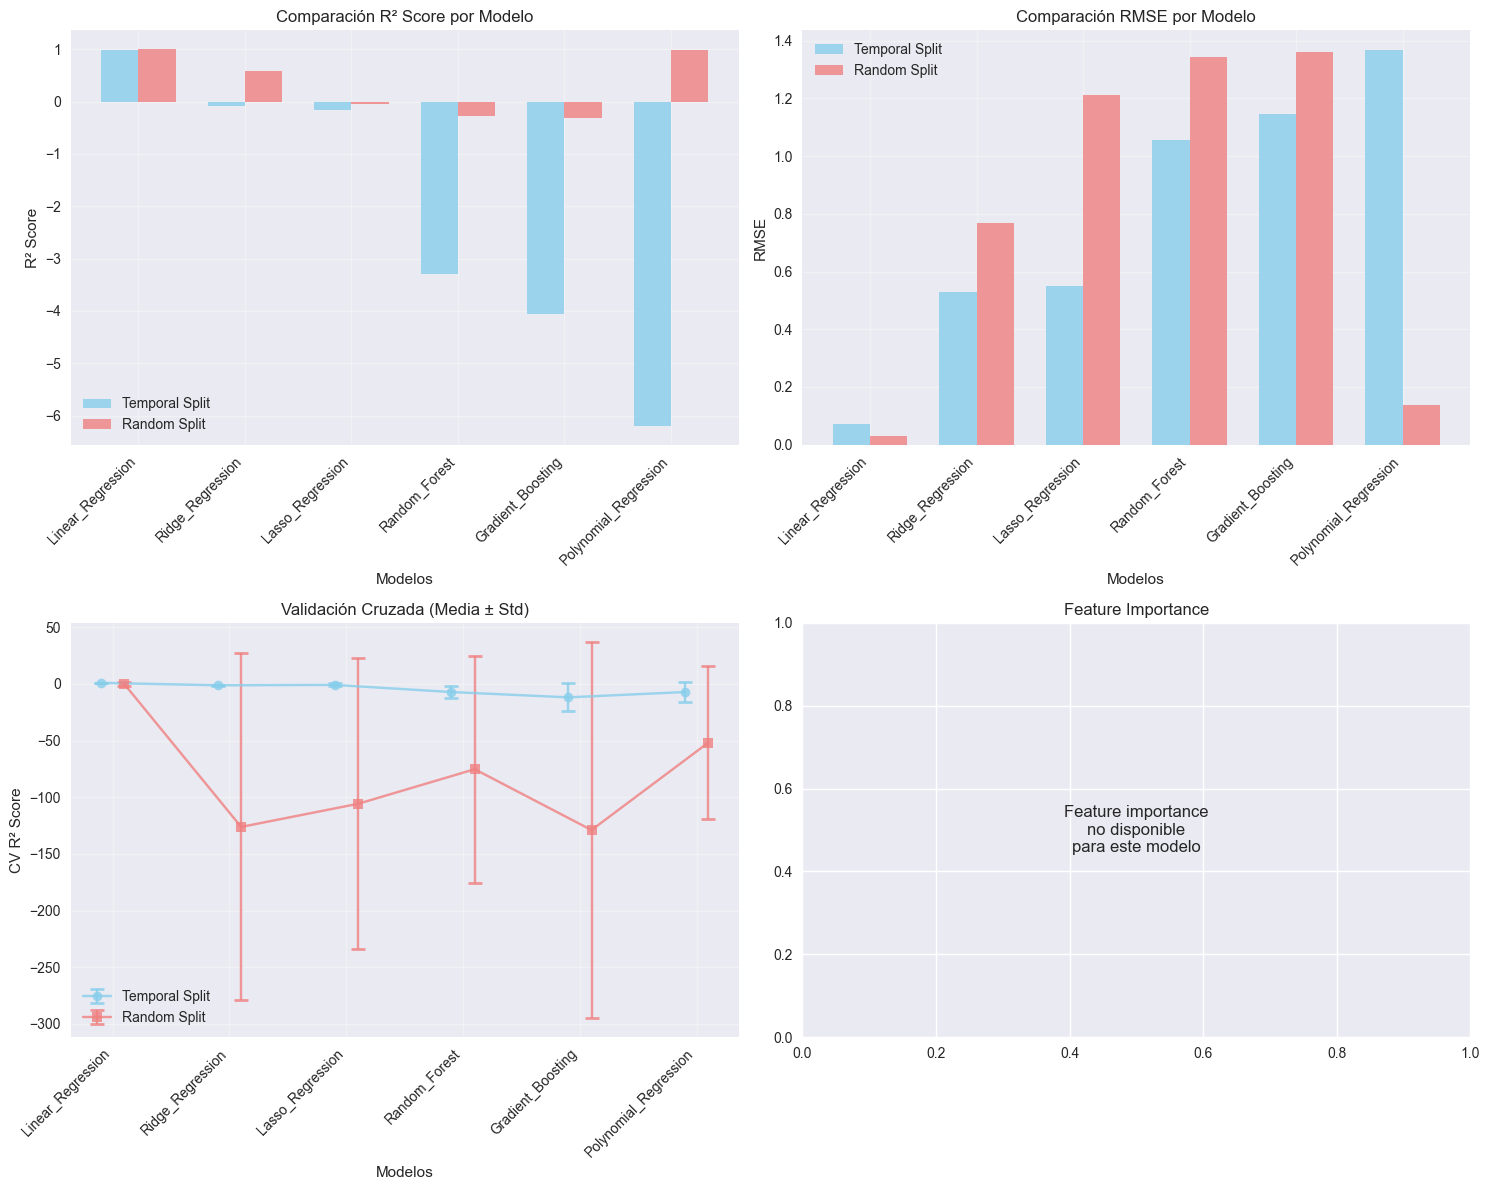

In [30]:
# Crear tabla comparativa de resultados
def create_results_comparison(results_temporal, results_random):
    """
    Crear tabla comparativa de resultados de modelos
    """
    comparison_data = []
    
    # Temporal split results
    for name, metrics in results_temporal.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Temporal',
            'R¬≤ Train': f"{metrics['train_r2']:.4f}",
            'R¬≤ Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R¬≤ (Œº¬±œÉ)': f"{metrics['cv_mean']:.4f}¬±{metrics['cv_std']:.4f}"
        })
    
    # Random split results
    for name, metrics in results_random.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Aleatorio',
            'R¬≤ Train': f"{metrics['train_r2']:.4f}",
            'R¬≤ Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R¬≤ (Œº¬±œÉ)': f"{metrics['cv_mean']:.4f}¬±{metrics['cv_std']:.4f}"
        })
    
    return pd.DataFrame(comparison_data)

# Crear y mostrar tabla comparativa
if 'results_temporal' in locals() and 'results_random' in locals():
    comparison_df = create_results_comparison(results_temporal, results_random)
    
    print("COMPARACI√ìN DE MODELOS:")
    print("=" * 100)
    display(comparison_df)
    
    # Encontrar mejores modelos
    best_temporal = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    best_random = max(results_random.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"\nüèÜ MEJORES MODELOS:")
    print(f"Split Temporal: {best_temporal[0]} (R¬≤ = {best_temporal[1]['test_r2']:.4f})")
    print(f"Split Aleatorio: {best_random[0]} (R¬≤ = {best_random[1]['test_r2']:.4f})")
    
    # Visualizar comparaci√≥n de m√©tricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # R¬≤ Score comparison
    models_names = list(results_temporal.keys())
    r2_temporal = [results_temporal[name]['test_r2'] for name in models_names]
    r2_random = [results_random[name]['test_r2'] for name in models_names]
    
    x = np.arange(len(models_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, r2_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, r2_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Modelos')
    axes[0,0].set_ylabel('R¬≤ Score')
    axes[0,0].set_title('Comparaci√≥n R¬≤ Score por Modelo')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    rmse_temporal = [results_temporal[name]['test_rmse'] for name in models_names]
    rmse_random = [results_random[name]['test_rmse'] for name in models_names]
    
    axes[0,1].bar(x - width/2, rmse_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,1].bar(x + width/2, rmse_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,1].set_xlabel('Modelos')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('Comparaci√≥n RMSE por Modelo')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Cross-validation scores
    cv_temporal = [results_temporal[name]['cv_mean'] for name in models_names]
    cv_temporal_std = [results_temporal[name]['cv_std'] for name in models_names]
    cv_random = [results_random[name]['cv_mean'] for name in models_names]
    cv_random_std = [results_random[name]['cv_std'] for name in models_names]
    
    axes[1,0].errorbar(x - 0.1, cv_temporal, yerr=cv_temporal_std, fmt='o-', label='Temporal Split', 
                       capsize=5, capthick=2, alpha=0.8, color='skyblue')
    axes[1,0].errorbar(x + 0.1, cv_random, yerr=cv_random_std, fmt='s-', label='Random Split', 
                       capsize=5, capthick=2, alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Modelos')
    axes[1,0].set_ylabel('CV R¬≤ Score')
    axes[1,0].set_title('Validaci√≥n Cruzada (Media ¬± Std)')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Feature importance for best model (if available)
    best_model_name, best_model_results = best_temporal
    best_model = best_model_results['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = X_train.columns
        
        # Ordenar por importancia
        indices = np.argsort(feature_importance)[::-1]
        
        axes[1,1].bar(range(len(feature_importance)), feature_importance[indices], alpha=0.8, color='green')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Importancia')
        axes[1,1].set_title(f'Importancia de Features - {best_model_name}')
        axes[1,1].set_xticks(range(len(feature_importance)))
        axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Feature importance\nno disponible\npara este modelo', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
else:    
    print("No hay resultados de modelos para evaluar")

## 9. Predictions and Visualization

Generamos predicciones y creamos visualizaciones comparativas.

Visualizando predicciones del mejor modelo: Linear_Regression


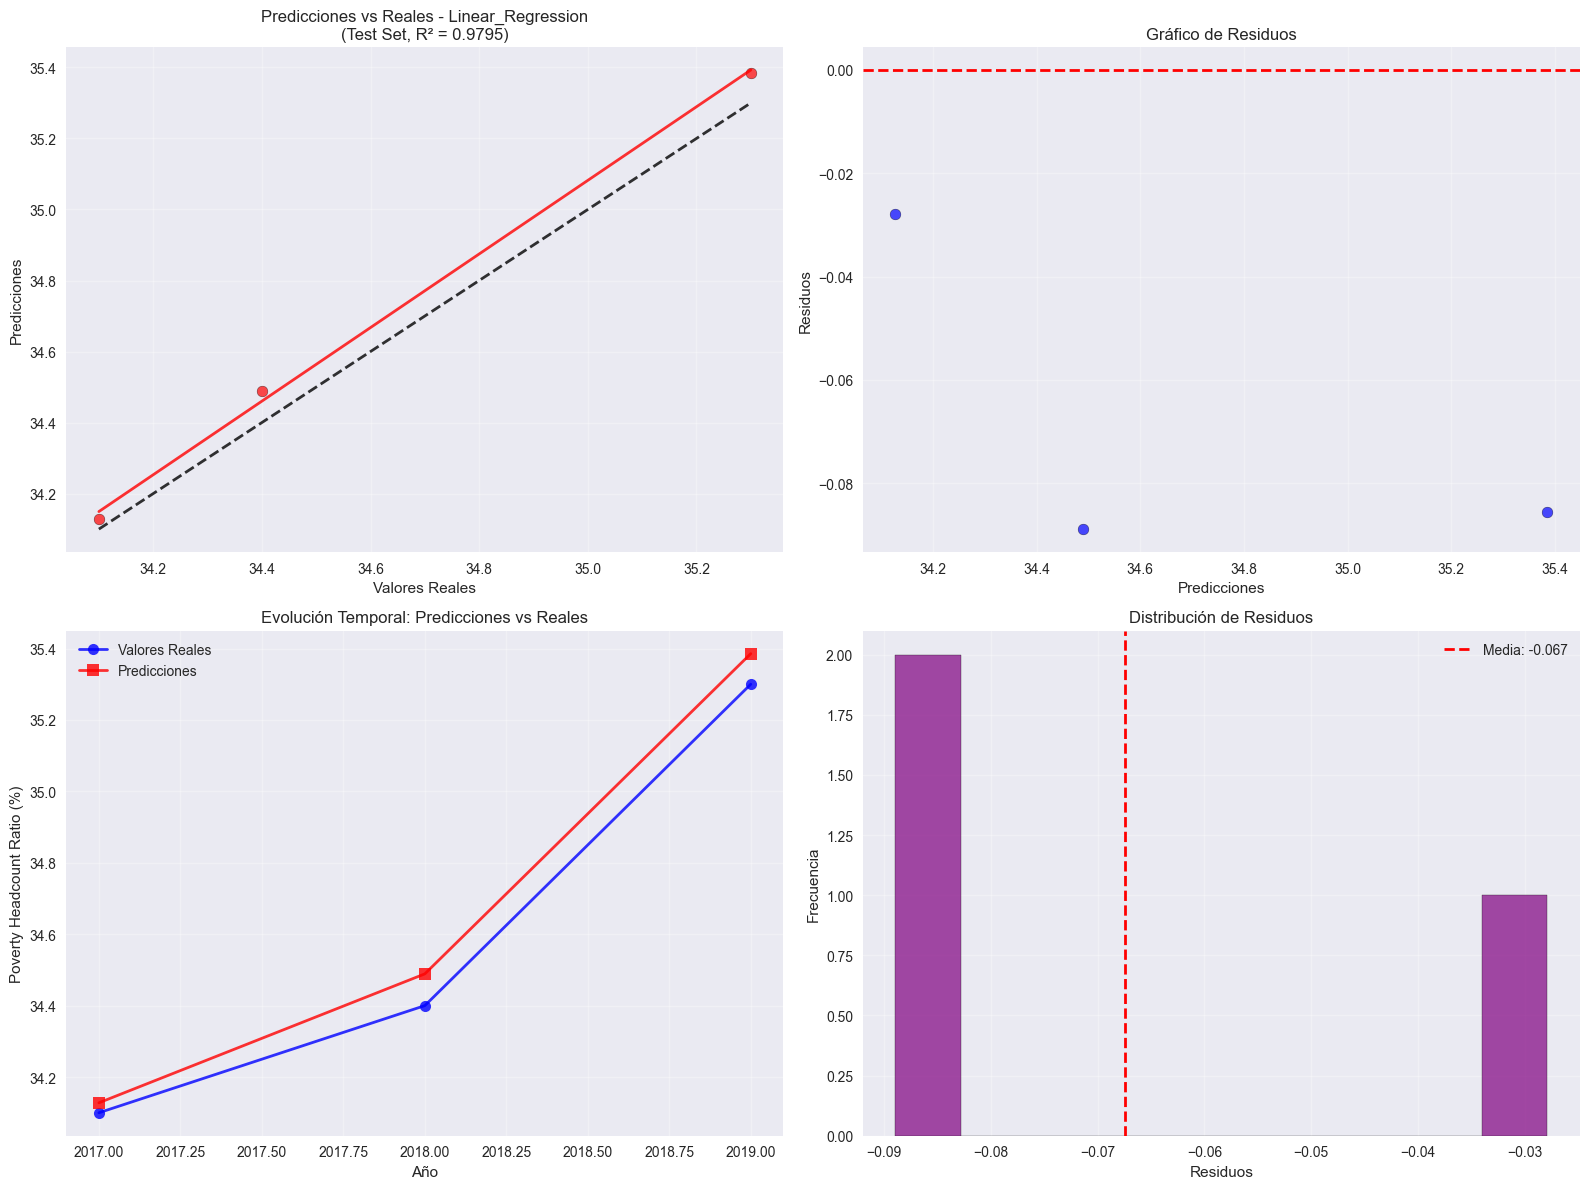

In [35]:
# Visualizaciones de predicciones vs valores reales
if 'results_temporal' in locals() and 'results_random' in locals():
    
    # Obtener mejor modelo
    best_model_name, best_model_results = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"Visualizando predicciones del mejor modelo: {best_model_name}")
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predicciones vs Valores Reales (Test Set)
    y_test_pred = best_model_results['y_pred_test']
    
    axes[0,0].scatter(y_test, y_test_pred, alpha=0.7, color='red', s=60, edgecolors='black')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name}\n(Test Set, R¬≤ = {best_model_results["test_r2"]:.4f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # A√±adir l√≠nea de regresi√≥n
    z = np.polyfit(y_test, y_test_pred, 1)
    p = np.poly1d(z)
    axes[0,0].plot(y_test, p(y_test), "r-", alpha=0.8, linewidth=2)
    
    # 2. Residuos
    residuals = y_test - y_test_pred
    axes[0,1].scatter(y_test_pred, residuals, alpha=0.7, color='blue', s=60, edgecolors='black')
    axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Gr√°fico de Residuos')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Series temporales (si tenemos a√±os)
    if 'years_test' in locals():
        axes[1,0].plot(years_test, y_test, 'o-', label='Valores Reales', 
                       color='blue', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].plot(years_test, y_test_pred, 's-', label='Predicciones', 
                       color='red', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].set_xlabel('A√±o')
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)')
        axes[1,0].set_title('Evoluci√≥n Temporal: Predicciones vs Reales')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].bar(['Train R¬≤', 'Test R¬≤', 'CV R¬≤'], 
                      [best_model_results['train_r2'], best_model_results['test_r2'], best_model_results['cv_mean']],
                      color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
        axes[1,0].set_ylabel('R¬≤ Score')
        axes[1,0].set_title('M√©tricas del Mejor Modelo')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribuci√≥n de errores
    axes[1,1].hist(residuals, bins=10, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Media: {residuals.mean():.3f}')
    axes[1,1].set_xlabel('Residuos')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title('Distribuci√≥n de Residuos')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla de predicciones detalladas
    predictions_df = pd.DataFrame({
        'A√±o': years_test if 'years_test' in locals() else range(len(y_test)),
        'Valor_Real': y_test.values,
        'Predicci√≥n': y_test_pred,
        'Error_Absoluto': np.abs(residuals),
        'Error_Porcentual': np.abs(residuals) / y_test.values * 100
    })
    
else:
    print("No hay resultados de modelos para visualizar")

## üìà Predicciones Futuras hasta 2030

Generamos predicciones del Poverty Headcount Ratio para Honduras hasta el a√±o 2030 usando el mejor modelo entrenado.

In [32]:
# Generar predicciones futuras hasta 2030
def generate_future_predictions(best_model_results, model_data_clean, feature_columns, target_years=range(2023, 2031)):
    """
    Genera predicciones futuras basadas en el mejor modelo entrenado
    """
    print("Generando predicciones futuras hasta 2030...")
    
    # Obtener el mejor modelo
    best_model = best_model_results['model']
    
    # Obtener los datos hist√≥ricos para calcular tendencias
    historical_data = model_data_clean.copy()
    last_year = historical_data['Year'].max()
    
    # Crear dataframe para a√±os futuros
    future_predictions = []
    
    for year in target_years:
        # Crear features para el a√±o futuro basado en patrones hist√≥ricos
        future_features = {}
        
        # Features temporales
        year_range = historical_data['Year'].max() - historical_data['Year'].min()
        future_features['Year_normalized'] = (year - historical_data['Year'].min()) / year_range if year_range > 0 else 0
        future_features['Year_squared'] = year ** 2
        future_features['Time_trend'] = len(historical_data) + (year - last_year - 1)
        
        # Para features de lag, usar la tendencia de los √∫ltimos a√±os
        if 'Poverty_lag1' in feature_columns:
            # Calcular tendencia promedio de los √∫ltimos 3 a√±os disponibles
            recent_data = historical_data.tail(3)['Poverty_Headcount_Ratio']
            if len(recent_data) > 1:
                trend = recent_data.diff().mean()
                if pd.isna(trend):
                    trend = 0
                # Proyectar basado en la tendencia
                last_value = historical_data['Poverty_Headcount_Ratio'].iloc[-1]
                future_features['Poverty_lag1'] = last_value + trend * (year - last_year - 1)
            else:
                future_features['Poverty_lag1'] = historical_data['Poverty_Headcount_Ratio'].iloc[-1]
        
        # Para features de cambio porcentual, usar promedio hist√≥rico
        for col in feature_columns:
            if col.endswith('_change') and col not in future_features:
                base_col = col.replace('_change', '')
                if base_col in historical_data.columns:
                    avg_change = historical_data[col].mean()
                    if pd.isna(avg_change):
                        avg_change = 0
                    future_features[col] = avg_change
        
        # Para features de Excel (si existen), proyectar basado en correlaci√≥n
        if 'Poverty_Excel_Indicator' in historical_data.columns:
            excel_corr = historical_data[['Poverty_Headcount_Ratio', 'Poverty_Excel_Indicator']].corr().iloc[0,1]
            if not pd.isna(excel_corr):
                # Proyectar Excel indicator basado en correlaci√≥n
                historical_excel_trend = historical_data['Poverty_Excel_Indicator'].diff().mean()
                if pd.isna(historical_excel_trend):
                    historical_excel_trend = 0
                last_excel = historical_data['Poverty_Excel_Indicator'].iloc[-1]
                projected_excel = last_excel + historical_excel_trend * (year - last_year)
                
                if 'Poverty_Excel_lag1' in feature_columns:
                    future_features['Poverty_Excel_lag1'] = projected_excel
                if 'Poverty_Ratio_CSV_Excel' in feature_columns:
                    future_features['Poverty_Ratio_CSV_Excel'] = future_features.get('Poverty_lag1', 0) / (projected_excel + 0.001)
                if 'Poverty_Diff_CSV_Excel' in feature_columns:
                    future_features['Poverty_Diff_CSV_Excel'] = future_features.get('Poverty_lag1', 0) - projected_excel
        
        # Asegurar que todas las features necesarias est√©n presentes
        feature_vector = []
        for col in feature_columns:
            if col in future_features:
                feature_vector.append(future_features[col])
            else:
                # Para features faltantes, usar promedio hist√≥rico o 0
                if col in historical_data.columns:
                    avg_val = historical_data[col].mean()
                    feature_vector.append(avg_val if not pd.isna(avg_val) else 0)
                else:
                    feature_vector.append(0)
        
        # Crear DataFrame para predicci√≥n
        X_future = pd.DataFrame([feature_vector], columns=feature_columns)
        
        # Generar predicci√≥n
        try:
            prediction = best_model.predict(X_future)[0]
            
            # Asegurar que la predicci√≥n sea realista (no negativa, no extrema)
            prediction = max(0, min(prediction, 100))
            
            future_predictions.append({
                'Year': year,
                'Predicted_Poverty_Ratio': prediction
            })
            
        except Exception as e:
            print(f"Error prediciendo {year}: {e}")
            # Usar extrapolaci√≥n simple como fallback
            if future_predictions:
                last_pred = future_predictions[-1]['Predicted_Poverty_Ratio']
                future_predictions.append({
                    'Year': year,
                    'Predicted_Poverty_Ratio': last_pred
                })
            else:
                future_predictions.append({
                    'Year': year,
                    'Predicted_Poverty_Ratio': historical_data['Poverty_Headcount_Ratio'].iloc[-1]
                })
    
    return pd.DataFrame(future_predictions)

# Generar predicciones si tenemos el mejor modelo
if 'best_model_results' in locals() and 'model_data_clean' in locals():
    future_df = generate_future_predictions(best_model_results, model_data_clean, feature_columns)
    
    print(f"\nPREDICCIONES FUTURAS GENERADAS:")
    print("=" * 50)
    display(future_df.round(2))
    
    # Combinar datos hist√≥ricos y predicciones para visualizaci√≥n
    historical_summary = model_data_clean[['Year', 'Poverty_Headcount_Ratio']].copy()
    historical_summary = historical_summary.rename(columns={'Poverty_Headcount_Ratio': 'Historical_Poverty_Ratio'})
    
    # Crear dataset completo
    complete_timeline = pd.merge(
        historical_summary, 
        future_df.rename(columns={'Predicted_Poverty_Ratio': 'Future_Poverty_Ratio'}), 
        on='Year', 
        how='outer'
    ).sort_values('Year')
    
    print(f"\nRESUMEN COMPLETO (2010-2030):")
    print("=" * 50)
    display(complete_timeline.round(2))
    
else:
    print("No se pueden generar predicciones - falta el modelo entrenado o datos")

Generando predicciones futuras hasta 2030...

PREDICCIONES FUTURAS GENERADAS:


Year  Predicted_Poverty_Ratio
0  2023                    33.79
1  2024                    35.07
2  2025                    36.34
3  2026                    37.60
4  2027                    38.86
5  2028                    40.12
6  2029                    41.36
7  2030                    42.60


RESUMEN COMPLETO (2010-2030):


Year  Historical_Poverty_Ratio  Future_Poverty_Ratio
0   2011                      34.9                   NaN
1   2012                      37.3                   NaN
2   2013                      35.4                   NaN
3   2014                      35.1                   NaN
4   2015                      35.5                   NaN
5   2016                      35.7                   NaN
6   2017                      34.1                   NaN
7   2018                      34.4                   NaN
8   2019                      35.3                   NaN
9   2023                       NaN                 33.79
10  2024                       NaN                 35.07
11  2025                       NaN                 36.34
12  2026                       NaN                 37.60
13  2027                       NaN                 38.86
14  2028                       NaN                 40.12
15  2029                       NaN                 41.36
16  2030                       NaN                 42.60

In [36]:
# Visualizaci√≥n de predicciones futuras
if 'future_df' in locals() and 'complete_timeline' in locals():
    
    print("Creando visualizaciones de predicciones futuras...")
    
    # Crear visualizaci√≥n completa
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Predicciones del Poverty Headcount Ratio en Honduras (2010-2030)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Serie temporal completa (hist√≥rico + predicciones)
    historical_years = complete_timeline.dropna(subset=['Historical_Poverty_Ratio'])['Year']
    historical_values = complete_timeline.dropna(subset=['Historical_Poverty_Ratio'])['Historical_Poverty_Ratio']
    
    future_years = complete_timeline.dropna(subset=['Future_Poverty_Ratio'])['Year']
    future_values = complete_timeline.dropna(subset=['Future_Poverty_Ratio'])['Future_Poverty_Ratio']
    
    # Gr√°fico principal
    axes[0,0].plot(historical_years, historical_values, 'o-', linewidth=3, markersize=8, 
                   color='blue', label='Datos Hist√≥ricos', alpha=0.8)
    axes[0,0].plot(future_years, future_values, 's--', linewidth=3, markersize=8, 
                   color='red', label='Predicciones Futuras', alpha=0.8)
    
    # L√≠nea vertical separando hist√≥rico de predicciones
    last_historical_year = historical_years.max()
    axes[0,0].axvline(x=last_historical_year, color='gray', linestyle=':', alpha=0.7, 
                      label=f'√öltimo a√±o hist√≥rico ({int(last_historical_year)})')
    
    axes[0,0].set_xlabel('A√±o', fontsize=12)
    axes[0,0].set_ylabel('Poverty Headcount Ratio (%)', fontsize=12)
    axes[0,0].set_title('Evoluci√≥n Temporal: Hist√≥rico vs Predicciones', fontsize=13, fontweight='bold')
    axes[0,0].legend(fontsize=10)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(2010, 2030)
    
    # 2. An√°lisis de tendencia
    if len(future_values) > 1:
        # Calcular tendencia futura
        future_trend = np.polyfit(range(len(future_values)), future_values, 1)[0]
        trend_direction = "Creciente" if future_trend > 0 else "Decreciente" if future_trend < 0 else "Estable"
        
        axes[0,1].bar(['2010-2019\n(Hist√≥rico)', '2020-2022\n(Hist√≥rico)', '2023-2030\n(Predicciones)'],
                      [historical_values.mean(), 
                       historical_values.tail(3).mean() if len(historical_values) >= 3 else historical_values.mean(),
                       future_values.mean()],
                      color=['skyblue', 'lightblue', 'lightcoral'], alpha=0.8, edgecolor='black')
        
        axes[0,1].set_ylabel('Poverty Ratio Promedio (%)', fontsize=12)
        axes[0,1].set_title(f'Comparaci√≥n por Per√≠odos\nTendencia Futura: {trend_direction}', 
                            fontsize=13, fontweight='bold')
        axes[0,1].grid(True, alpha=0.3)
        
        # A√±adir valores en las barras
        for i, v in enumerate([historical_values.mean(), 
                               historical_values.tail(3).mean() if len(historical_values) >= 3 else historical_values.mean(),
                               future_values.mean()]):
            axes[0,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Rango de incertidumbre (estimaci√≥n simple)
    if len(historical_values) > 1:
        historical_std = historical_values.std()
        
        # Crear bandas de confianza para predicciones
        upper_bound = future_values + historical_std
        lower_bound = future_values - historical_std
        
        axes[1,0].fill_between(future_years, lower_bound, upper_bound, 
                               alpha=0.3, color='red', label='Banda de Incertidumbre')
        axes[1,0].plot(future_years, future_values, 'r-', linewidth=2, 
                       label='Predicci√≥n Central', marker='s', markersize=6)
        axes[1,0].plot(historical_years, historical_values, 'b-', linewidth=2, 
                       label='Datos Hist√≥ricos', marker='o', markersize=6, alpha=0.7)
        
        axes[1,0].set_xlabel('A√±o', fontsize=12)
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)', fontsize=12)
        axes[1,0].set_title('Predicciones con Banda de Incertidumbre', fontsize=13, fontweight='bold')
        axes[1,0].legend(fontsize=10)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xlim(2015, 2030)
    
    # 4. Tabla resumen de predicciones clave
    key_years = [2025, 2030]
    key_predictions = future_df[future_df['Year'].isin(key_years)]
    
    if not key_predictions.empty:
        # Crear tabla visual
        table_data = []
        for _, row in key_predictions.iterrows():
            table_data.append([f"{int(row['Year'])}", f"{row['Predicted_Poverty_Ratio']:.1f}%"])
        
        # A√±adir datos hist√≥ricos clave para comparaci√≥n
        if not historical_values.empty:
            table_data.insert(0, ["2019 (Hist√≥rico)", f"{historical_values.iloc[-1]:.1f}%"])
        
        # Crear tabla
        table = axes[1,1].table(cellText=table_data,
                                colLabels=['A√±o', 'Poverty Ratio'],
                                cellLoc='center',
                                loc='center',
                                colColours=['lightblue', 'lightgreen'])
        
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)
        
        axes[1,1].axis('off')
        axes[1,1].set_title('Predicciones Clave', fontsize=13, fontweight='bold')
        
        # A√±adir estad√≠sticas adicionales
        if len(future_values) > 0:
            stats_text = f"""
            Estad√≠sticas de Predicciones (2023-2030):
            
            Promedio: {future_values.mean():.1f}%
            M√≠nimo: {future_values.min():.1f}%
            M√°ximo: {future_values.max():.1f}%
            
            Cambio proyectado (2023-2030):
            {future_values.iloc[-1] - future_values.iloc[0]:+.1f} puntos porcentuales
            """
            
            axes[1,1].text(0.02, 0.02, stats_text, transform=axes[1,1].transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"),
                           fontsize=10, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("‚ùå No se pueden crear visualizaciones - faltan datos de predicciones")

Creando visualizaciones de predicciones futuras...
